# Dataset de Tweets para Análisis de Sentimientos

## Capturamos un train y un test de tweets previamente seleccionados por una competencia

Los detalles de la competencia **gratuita** pueden encontrarse en la siguiente web: [https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/](https://)

In [1]:
import pandas as pd
train=pd.read_csv('https://raw.githubusercontent.com/HackSpacePeru/Datasets_intro_Data_Science/master/Nlp_twitter/train_twitter_analysis.csv')
test=pd.read_csv('https://raw.githubusercontent.com/HackSpacePeru/Datasets_intro_Data_Science/master/Nlp_twitter/test_twitter_analysis.csv')

## Importamos las librerías

In [2]:
import re    # regular expression nos permite ubicar con mayor facilidad el texto que queramos.
import nltk  # natural language Toolkit es una librería para nlp

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#Usualmente veremos esto cuando queremos asegurarnos que el gráfico se guarde en el notebook.
%matplotlib inline

In [3]:
#Definimos un máximo de ancho de columna para ver mejor los textos
pd.set_option("display.max_colwidth", 200)

## Pequeña exploración de la data

In [4]:
#Visualizamos el tamaño de cada dataset
train.shape, test.shape

((31962, 3), (17197, 2))

La competencia nos pide predecir si un tweet es **racista o sexista**. Para ello tenemos data que ya se ha clasificado como racista o sexista. Por eso, tenemos una columna label que nos dirá si el tweet es o no ofensivo.

Veamos cómo son los tweets de cada categoría:

In [5]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


In [6]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
77,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
82,83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
111,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦


Podemos distinguir **cuántos** de los tweets en train son racistas o sexistas y cuántos no con un simple *value_counts* de la columna label

Solo el 7% de los datos del dataset train contienen tweets clasificados como racista o sexista. Esto se conoce como **data desbalanceada** y existen técnicas para solucionar este problema. Pueden encontrar mayor información en [https://www.kdnuggets.com/2019/05/fix-unbalanced-dataset.html](https://)


**Nota**: En este notebook no se hará un tratamiento al desbalanceo de la data. Por eso se espera un porcentaje bajo de accuracy en las predicciones.

**¿Cuánto es el tamaño de nuestros tweets, tanto en train como en test?** 

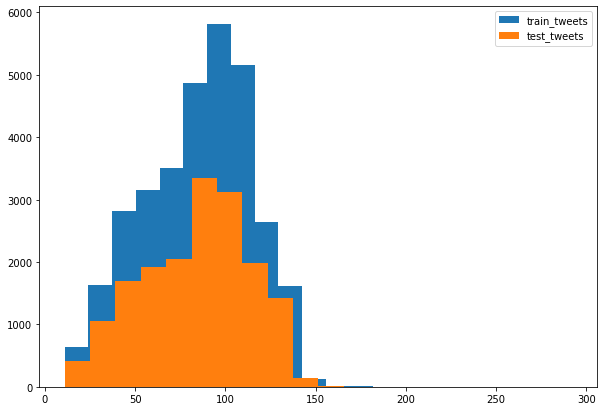

In [7]:
length_train = train['tweet'].str.len() 
length_test = test['tweet'].str.len() 
plt.figure(figsize=(10,7))
plt.hist(length_train, bins=20, label="train_tweets") #el comando hist de la librería matplotlib (plt) permite dibujar histogramas
plt.hist(length_test, bins=20, label="test_tweets") #el parámetro label es para identificar estos datos para una leyenda del gráfico
plt.legend() #el comando legend añade una leyenda al gráfico
plt.show()

Podemos ver que en suma, los tweets tienen la misma forma. Pero que tenemos hay **mayor cantidad de data dentro de train** y que la media de caracteres en nuestro dataset es de 100 aproximadamente. 

## Tratamiento de la data

En esta sección procederemos a eliminar de los datos los caracteres que nos impiden clasificar mejor los tweets (por ejemplo signos de puntuación)

In [8]:
#Inicialmente juntamos train y test para realizar este tratamiento para ambos dataset. Luego volveremos a dividirlos.

#Nos ahorraremos en repetir los comandos para train y test.
combi = train.append(test, ignore_index=True) 
combi.shape

(49159, 3)

### Limpiando nuestra data

In [9]:
#Definimos una función para eliminar de los tweets alguna palabra, simbolo o caracter especial (que irá en el parámetro pattern) que creamos conveniente
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [10]:
#Quitamos todas aquellas menciones dentro de los tweets a otros usuarios (que comienzan con @)

#vectorizamos nuestra función para aplicarla luego a nuestra data:
vector_function = np.vectorize(remove_pattern)
combi['tidy_tweet'] = vector_function(combi['tweet'], "@[\w]*")  #aplicamos la función especificando los parámetros
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [11]:
#Reemplazamos todos aquellos carácteres especiales como signos de puntuación por un espacio en blanco
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") #el simbolo ^ nos agarra "todo menos" en este caso palabras y números 
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare and big talking before they leave chaos and pay disputes when they get there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams can t think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won love the land #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here i m it s so #gr


In [12]:
#Removemos todas aquellas palabras con un largo de 3 caracteres o menos que podrían incluir conectores, advervios, artículos (por ejemplo a, and, the)
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combi.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fare talking before they leave chaos disputes when they there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exams think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here


## Tokenización y Steamming

Para poder evaluar cada tweet será necesario dividirlo en palabras, este proceso se denomina *tokenization*.

También realizaremos el proceso denominado *steamming* para solo utilizar las raíces de las palabras en el análisis (por ejemplo "read" en vez de "reading")

In [13]:
#Dividimos los tweets en palabras y guardamos el resultado en una variable denominada tokenized_tweet
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) #el comando split signfica dividir
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [14]:
#Ahora procederemos a extraer solo la raíz de las palabras para un mejor análisis y actualizamos nuestra variable tokenized_tweet
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [15]:
#Finalmente juntamos cada raíz de palabra para almacenarla nuevamente en la columna tidy_tweet
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['tidy_tweet'] = tokenized_tweet

In [32]:
combi[combi['label'] == 1]

,id,label,tweet,tidy_tweet
13,14,1.0,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot,#cnn call #michigan middl school build wall chant #tcot
14,15,1.0,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins,comment #australia #opkillingbay #seashepherd #helpcovedolphin #thecov #helpcovedolphin
17,18,1.0,retweet if you agree!,retweet agre
23,24,1.0,@user @user lumpy says i am a . prove it lumpy.,lumpi say prove lumpi
34,35,1.0,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia,unbeliev that centuri need someth like thi again #neverump #xenophobia
...,...,...,...,...
31934,31935,1.0,lady banned from kentucky mall. @user #jcpenny #kentucky,ladi ban from kentucki mall #jcpenni #kentucki
31946,31947,1.0,@user omfg i'm offended! i'm a mailbox and i'm proud! #mailboxpride #liberalisme,omfg offend mailbox proud #mailboxprid #liberalism
31947,31948,1.0,@user @user you don't have the balls to hashtag me as a but you say i am to weasel away.. lumpy tony.. dipshit.,have ball hashtag weasel away lumpi toni dipshit
31948,31949,1.0,"makes you ask yourself, who am i? then am i anybody? until ....god . oh thank you god!",make yourself then anybodi until thank


## Visualización de palabras más usadas y hashtag

En esta sección utilizaremos el método **wordcloud** para identificar palabras más usadas

Además visualizaremos histogramas para identificar los hashtag (#) más usados.

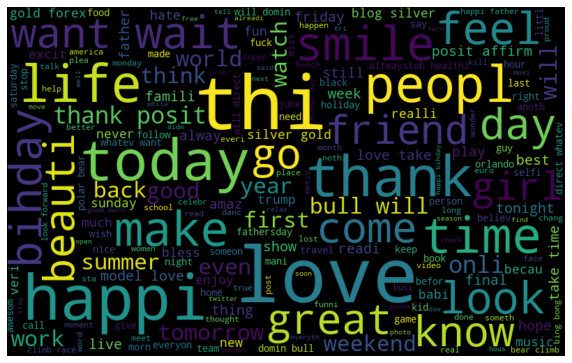

In [17]:
#Importamos la librería WordCloud para visualizar las palabras más usadas (que aparecen en mayor tamaño) en la columna tidy_tweet completa que denominamos all_words
from wordcloud import WordCloud

all_words = ' '.join([text for text in combi['tidy_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Repetimos el mismo análisis **solo para aquellos tweets que estén caracterizados como no racistas ni sexistas** (label=0) que denominamos normal_words

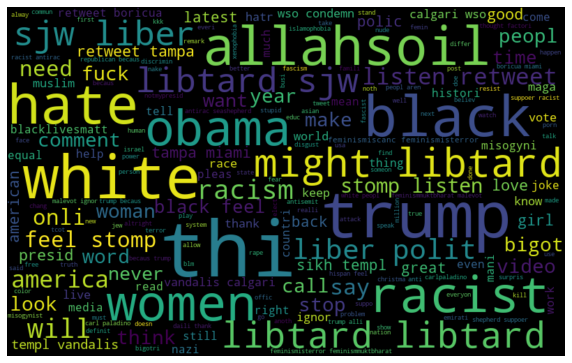

In [36]:
from wordcloud import WordCloud
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Y por último realizamos el mismo análisis para aquellos **tweets que estén caracterizados como racistas ni sexistas** (label=1) que denominamos negative_words

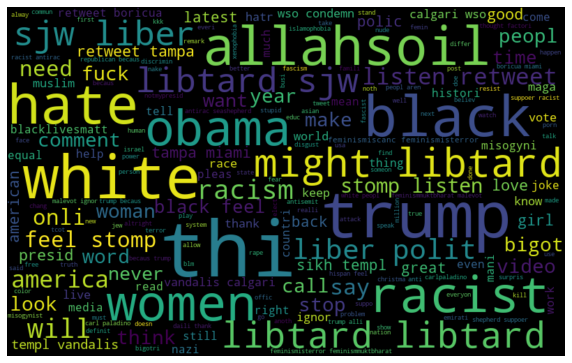

In [19]:
from wordcloud import WordCloud

negative_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Para argumentar con **números** el impacto de las palabras dentro del dataset, train y test, vamos a realizar un **gráfico de barras** con ayuda del método displot.

In [20]:
# Definimos una función que nos permita extraer los hashtags (#) de los tweets
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [21]:
#Extraemos los hashtags (#) de los tweets que no son racistas ni sexistas (label=0) y guardamos el resultado en la variable HT_regular
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

In [22]:
#Extraemos los hashtags (#) de los tweets que sí son racistas y sexistas (label=1) y guardamos el resultado en la variable HT_negative 
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

In [23]:
#Para poder realizar un conteo y graficarlo en barras procedemos a unir todas las palabras de cada variable
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

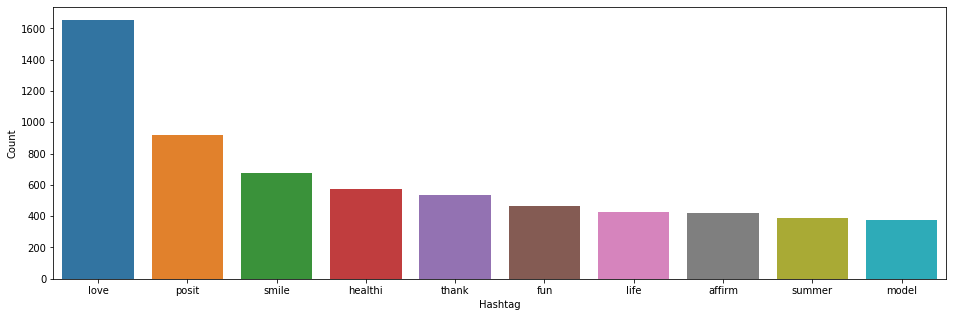

In [24]:
#Con ayuda del método FreqDist de realizamos el conteo y graficamos las frecuencias de aparición de cada hashtag en los tweets de la variable HT_regular (label=0)
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
d = d.nlargest(columns="Count", n = 10) #Para efectos de visualización solo nos quedaremos con el top10
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") #Para
ax.set(ylabel = 'Count')
plt.show()

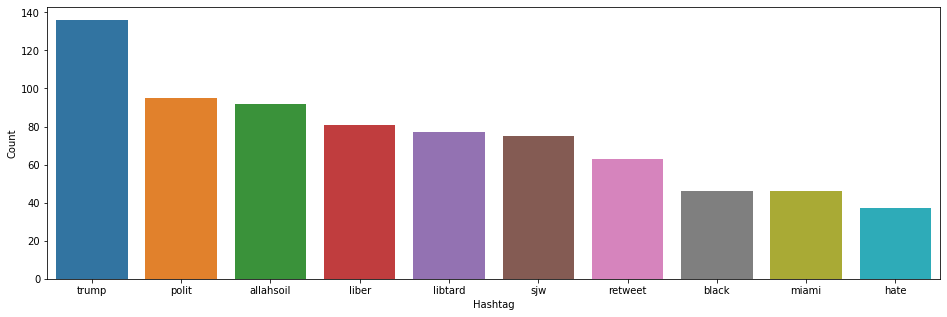

In [25]:
#Con ayuda del método FreqDist de realizamos el conteo y graficamos las frecuencias de aparición de cada hashtag en los tweets de la variable HT_negative (label=1)
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
e = e.nlargest(columns="Count", n = 10)   #Para efectos de visualización solo nos quedaremos con el top10
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

## Preprocesamiento de la data ( I ): Bag of Words

El primer método para preparar la data y poder ejecutar modelos de clasificación se denomina **Bag of Words** donde se obtiene un dataset compuesto por D documentos (que representan filas o registros) y N corpus (que representan las variables predictoras)

Para nuestro ejemplo el objetivo es obtener como variables predictoras (columnas o *features*) las palabras y las filas o registros serán cada tweet.

In [37]:
#Importamos la librería CountVectorizer de sklearn
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english') #en nuestro caso estamos procesando tweets en inglés
bow = bow_vectorizer.fit_transform(combi['tidy_tweet']) #guardamos el resultado en una variable denominada bow

## Preprocesamiento de la data ( II ): TF - IDF

El segundo método para preparar la data y poder ejecutar modelos de clasificación se denomina **TF - IDF** donde se obtiene un dataset conformado por los mismos elementos. Sin embargo vamos a añadir dos elementos de evaluación (como pesos para cada variable):


1.   TF = # veces que aparece una palabra en un solo documento / # palabras totales de ese mismo documento
2.   IDF = log (N/n) n es el # veces que aparece una palabra en cada documento y N es el # total de documentos


Para nuestro ejemplo recordemos que un documento es un tweet y una palabra es cada una de las palabras que hemos tokenizado y steammeado.

In [40]:
#Importamos la librería TfidVectorizer de sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english') #en nuestro caso estamos procesando tweets en inglés
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet']) #guardamos el resultado en una variable denominada tfidf

In [44]:
print(tfidf)

  (0, 738)	0.6577413621857342
  (0, 463)	0.5896490179849546
  (0, 302)	0.46871135687055143
  (1, 600)	0.6835218920644196
  (1, 131)	0.6145629375807904
  (1, 879)	0.3938403468675415
  (2, 79)	1.0
  (3, 888)	0.5572995329862621
  (3, 518)	0.44016705593507854
  (3, 557)	0.7040384885805177
  (4, 566)	1.0
  (5, 485)	0.4652198168550412
  (5, 69)	0.4637175931713698
  (5, 858)	0.4743403266916206
  (5, 423)	0.586120951905663
  (6, 894)	0.5868769751051355
  (6, 121)	0.809676118019697
  (7, 353)	0.19785820398515808
  (7, 432)	0.298367397816037
  (7, 393)	0.22953868678391207
  (7, 883)	0.20713435439054187
  (7, 283)	0.6221668428341786
  (7, 992)	0.40382612331421974
  (7, 749)	0.47546741144240784
  (8, 132)	0.689689021511751
  :	:
  (49154, 728)	0.293909942896328
  (49155, 246)	0.6332778044821932
  (49155, 961)	0.532509130693973
  (49155, 307)	0.412937926376108
  (49155, 498)	0.38062516605968433
  (49156, 122)	0.3818217223390089
  (49156, 411)	0.37375293461862846
  (49156, 929)	0.30556509026170586
 

## Preprocesamiento de la data ( III ): Word2Vec

El tercer método para preparar la data y poder ejecutar modelos de clasificación se denomina **Word2Vec** donde cada palabra se transforma en un vector para relacionar las palabras entre sí antes de generar el dataset. Esto nos trae dos ventajas:


1.   Se reduce significativamente la cantidad de columnas generadas
2.   Se puede brindar dos significados distintos para una misma palabra (por ejemplo *apple* puede significar fruta y también signficar empresa tecnológica)

In [28]:
#Dividimos nuevamente la columna tidy_tweet palabra por palabra para poder realizar el análisis y guardamos el resultado en la variable tokenized_tweet
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())

In [45]:
#Importamos las librerías que necesitamos para ejecutar el análisis Word2vec
import gensim

from gensim.models.doc2vec import LabeledSentence

In [46]:
#Generamos un modelo word2vec y guardamos el modelo en la variable model_w2v
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200,
            window=5,
            min_count=2,
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 2,
            seed = 34)

In [47]:
#Entrenamos el modelo con los tweets tokenizados
model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6510526, 7536020)

In [48]:
#Probamos el modelo entrenado para encontrar las palabras más relacionadas con la palabra "dinner"
model_w2v.wv.most_similar(positive="dinner")

[('spaghetti', 0.5702472925186157),
 ('spinach', 0.5460582971572876),
 ('#cellar', 0.5457855463027954),
 ('#biall', 0.543486475944519),
 ('fav', 0.5433900952339172),
 ('noodl', 0.5433034300804138),
 ('#pasta', 0.5364086031913757),
 ('#avocado', 0.5306267738342285),
 ('burrito', 0.5286197066307068),
 ('cookout', 0.5285967588424683)]

In [49]:
#Definimos una función para generar un vector para cada uno de los tweet
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size)) #creo mi espacio vectorial
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: continue
        if count != 0: vec/= count
    return vec

In [50]:
#Aplicamos la función sobre cada tweet y generamos un dataframe que guardaremos como la variable wordvec_df
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)

In [51]:
#Comprobamos el tamaño de la variable y visulizamos un total de 200 columnas
wordvec_df.shape

(49159, 200)

In [52]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.032672,-0.002757,0.029401,0.021691,0.066171,0.017459,-0.038341,-0.041571,-0.050545,0.052017,...,0.001804,-0.121505,-0.039320,-0.000093,-0.061341,0.064375,-0.043052,0.030602,0.066309,-0.050817
1,0.006441,0.010077,-0.008342,0.032119,0.005508,-0.006997,-0.008182,-0.021630,-0.010511,-0.000641,...,0.001782,-0.002961,0.002868,0.007377,-0.001041,0.021818,-0.013555,0.003675,0.020307,0.004233
2,0.162626,0.070097,0.136674,0.046684,0.077926,-0.219746,-0.097959,-0.046780,-0.161687,-0.046832,...,0.144874,-0.174816,0.140572,-0.056331,-0.068288,0.286346,-0.067923,-0.042172,-0.103684,0.055154
3,0.146685,-0.082647,0.124468,0.128025,0.101326,-0.140231,-0.059391,-0.026750,-0.050219,0.035729,...,-0.099424,-0.059463,0.039381,-0.050108,-0.049603,-0.000831,-0.007748,-0.050301,-0.029603,0.018341
4,0.023900,-0.182882,0.389061,0.431255,-0.018274,-0.034865,-0.151859,-0.168658,-0.226209,0.247742,...,-0.125666,-0.067353,-0.109950,-0.299186,-0.289061,0.165862,0.013686,0.276391,0.155849,-0.232978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,-0.029141,-0.011348,0.038094,0.016715,0.008226,0.010212,-0.024717,0.010138,-0.028217,-0.040890,...,0.009545,0.037135,-0.006703,-0.014274,0.041681,0.057970,-0.024615,0.032999,0.054383,-0.000581
49155,0.043656,-0.032436,0.007841,0.013007,0.044000,-0.018429,0.016392,-0.022479,0.001142,0.077870,...,0.007080,-0.029543,0.002484,0.032848,-0.019791,0.047460,-0.035192,0.027049,0.001986,0.020126
49156,0.013818,0.001287,0.013465,0.020400,-0.004378,-0.004524,-0.012111,-0.002286,-0.008092,-0.013465,...,-0.003889,-0.007497,-0.004685,-0.020268,-0.000601,0.013970,-0.008706,-0.010421,-0.001401,-0.004495
49157,0.013328,-0.048281,0.062572,0.066546,0.028146,-0.048515,-0.000540,-0.017550,0.023783,0.030086,...,0.034825,0.008297,0.014941,-0.049201,-0.045967,0.036303,-0.075978,0.025727,-0.003642,0.020974


Este último método nos ha brindado un dataset de 200 columnas, mientras que los anteriores métodos (BagOfWords y TF-IDF) resultan en promedio 1000 columnas.

## Regresión Logística a través de Bag of Words

In [53]:
#Importamos las librerías necesarias para efectar la regresión logística
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Actualmente bow tiene guardado todos los tweets (ya procesados según Bag Of Words) por ello lo separamos en train y test según el shape que efectuamos al inicio
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

#Utilizamos el método train_test_split para dividir nuestra data de entrenamiento (train_bow) en train y valid
xtrain_bow, xvalid_bow, ytrain_bow, yvalid_bow = train_test_split(train_bow, train['label'], test_size=0.3)

In [54]:
#Preparamos el modelo regresión logística solo en base a los datos de entrenamiento (xtrain_bow, ytrain_bow)
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
#Obtenemos las predicciones (probabilidades) del modelo de regresión logística utilizando los datos de validación (xvalid_bow)
prediction_bow = lreg.predict_proba(xvalid_bow)
prediction_int_bow = prediction_bow[:,1] >= 0.195 #Establecemos el punto de corte en 0.195
prediction_int_bow = prediction_int_bow.astype(np.int)

In [56]:
#Calculamos el indicador accuracy_score del modelo contrastando las predicciones con los target de validación (yvalid_bow)
f1_bow=accuracy_score(yvalid_bow, prediction_int_bow)
f1_bow

0.5553997194950911

In [72]:
from sklearn.metrics import accuracy_score

## Regresión Logística a través de TF -IDF

In [57]:
#Actualmente tfidf tiene guardado todos los tweets (ya procesados según TF-IDF) por ello lo separamos en train y test según el shape que efectuamos al inicio
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

#Utilizamos el método train_test_split para dividir nuestra data de entrenamiento (train_tfidf) en train y valid
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(train_tfidf, train['label'], test_size=0.3)

In [58]:
#Preparamos el modelo regresión logística solo en base a los datos de entrenamiento (xtrain_tfidf, ytrain_tfidf)
lreg = LogisticRegression()
lreg.fit(xtrain_tfidf, ytrain_tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
#Obtenemos las predicciones (probabilidades) del modelo de regresión logística utilizando los datos de validación (xvalid_tfidf)
prediction_tfidf = lreg.predict_proba(xvalid_tfidf)
prediction_int_tfidf = prediction_tfidf[:,1] >= 0.295 #Establecemos el punto de corte en 0.295
prediction_int_tfidf = prediction_int_tfidf.astype(np.int)

In [73]:
#Calculamos el indicador accuracy_score del modelo contrastando las predicciones con los target de validación (yvalid_tfidf)
f1_tfidf=accuracy_score(yvalid_tfidf, prediction_int_tfidf)
accuracy_score_lr = accuracy_score(yvalid_tfidf, prediction_int_tfidf)
print('accuracy_score:',accuracy_score_lr)

f1_score: 0.5657439446366782
accuracy_score: 0.9476483470643445


## Regresión Logística a través de Word2Vec

In [61]:
#Actualmente wordvec_df tiene guardado todos los tweets (ya procesados según word2vec) por ello lo separamos en train y test según el shape que efectuamos al inicio
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

In [62]:
#Utilizamos el método train_test_split para dividir nuestra data de entrenamiento (train_w2v) en train y valid
xtrain_w2v, xvalid_w2v, ytrain_w2v, yvalid_w2v = train_test_split(train_w2v, train['label'], test_size=0.3)

In [63]:
#Preparamos el modelo regresión logística solo en base a los datos de entrenamiento (xtrain_w2v, ytrain_w2v)
lreg = LogisticRegression()
lreg.fit(xtrain_w2v, ytrain_w2v)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
#Obtenemos las predicciones (probabilidades) del modelo de regresión logística utilizando los datos de validación (xvalid_w2v)
prediction_w2v = lreg.predict_proba(xvalid_w2v)
prediction_int_w2v = prediction_w2v[:,1] >= 0.1989 #Establecemos el punto de corte en 0.295
prediction_int_w2v = prediction_int_w2v.astype(np.int)

In [65]:
#Calculamos el indicador accuracy_score del modelo contrastando las predicciones con los target de validación (yvalid_w2v)
f1_w2v=accuracy_score(yvalid_w2v, prediction_int_w2v)
f1_w2v

0.48246844319775595

## RandomForest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
#Aplicamos el modelo de RandomForest para los datos procesados según Bag of Words y calculamos el indicador accuracy_score
rf_bow = RandomForestClassifier(n_estimators=400).fit(xtrain_bow, ytrain_bow)
prediction_rf_bow = rf_bow.predict(xvalid_bow)
f1_rf_bow=accuracy_score(yvalid_bow, prediction_rf_bow)

print('accuracy_score',accuracy_score(yvalid_bow, prediction_rf_bow))

0.5969230769230769

In [68]:
#Aplicamos el modelo de RandomForest para los datos procesados según TF-IDF y calculamos el indicador accuracy_score
rf_tfidf = RandomForestClassifier(n_estimators=400).fit(xtrain_tfidf, ytrain_tfidf)
prediction_rf_tfidf = rf_tfidf.predict(xvalid_tfidf)
f1_rf_tfidf=accuracy_score(yvalid_tfidf, prediction_rf_tfidf)

print('accuracy_score',accuracy_score(yvalid_tfidf, prediction_rf_tfidf))

0.5884509624197983

In [74]:
#Aplicamos el modelo de RandomForest para los datos procesados según Word2Vec y calculamos el indicador accuracy_score
rf_w2v = RandomForestClassifier(n_estimators=400,max_depth=6).fit(xtrain_w2v, ytrain_w2v)
prediction_rf_w2v = rf_w2v.predict(xvalid_w2v)
f1_rf_w2v=accuracy_score(yvalid_w2v, prediction_rf_w2v)

print('accuracy_score',accuracy_score(yvalid_w2v, prediction_rf_w2v))

f1_score: 0.15033557046979867
accuracy_score 0.9339868599436855


## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Aplicamos el modelo de XGBClassifier para los datos procesados según Bag of Words y calculamos el indicador accuracy_score
xgbc = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain_bow) 
prediction_xgbc_bow = xgbc.predict(xvalid_bow)
f1_xgbc_bow=accuracy_score(yvalid_bow, prediction_xgbc_bow)
print(f1_xgbc_bow)

In [ ]:
#Aplicamos el modelo de XGBClassifier para los datos procesados según TF-IDF y calculamos el indicador accuracy_score
xgbc = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain_tfidf) 
prediction_xgbc_tfidf = xgbc.predict(xvalid_tfidf)
f1_xgbc_tfidf=accuracy_score(yvalid_tfidf, prediction_xgbc_tfidf)
f1_xgbc_tfidf

In [ ]:
#Aplicamos el modelo de XGBClassifier para los datos procesados según Word2Vec y calculamos el indicador accuracy_score
xgbc = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_w2v, ytrain_w2v) 
prediction_xgbc_w2v = xgbc.predict(xvalid_w2v)
f1_xgbc_w2v=accuracy_score(yvalid_w2v, prediction_xgbc_w2v)
f1_xgbc_w2v

## Mejorando XGBoost + Word2Vec

In [ ]:
import xgboost as xgb

In [ ]:
%%time

dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain_w2v) 
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid_w2v) 
dtest = xgb.DMatrix(test_w2v)
# Parameters that we are going to tune 
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
 }

In [ ]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('accuracy_score', accuracy_score(labels, preds))]

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10)
     for min_child_weight in range(5,8)
 ]

In [ ]:
max_f1 = 0
best_params = None 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    cv_results = xgb.cv(params,
        dtrain,        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10)
    
    mean_f1 = cv_results['test-accuracy_score-mean'].max()
        
    boost_rounds = cv_results['test-accuracy_score-mean'].argmax()    
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
      max_f1 = mean_f1
      best_params = (max_depth,min_child_weight) 
      print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

In [ ]:
params['max_depth'] = 8 
params['min_child_weight'] = 6

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)] ]

In [ ]:
max_f1 = 0
best_params = None 
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(subsample,colsample))
    
    params['colsample'] = colsample
    params['subsample'] = subsample
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )
    
    mean_f1 = cv_results['test-accuracy_score-mean'].max()
    boost_rounds = cv_results['test-accuracy_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
      max_f1 = mean_f1
      best_params = (subsample, colsample) 
      print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

In [ ]:
params['subsample'] = .9 
params['colsample_bytree'] = .5

In [ ]:
max_f1 = 0. 
best_params = None 
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    
    params['eta'] = eta

    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    mean_f1 = cv_results['test-accuracy_score-mean'].max()
    boost_rounds = cv_results['test-accuracy_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta
        print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

In [ ]:
params['eta'] = .1

In [ ]:
params
{'colsample': 0.9,
 'colsample_bytree': 0.5, 'eta': 0.1,
 'max_depth': 8, 'min_child_weight': 6,
 'objective': 'binary:logistic',
 'subsample': 0.9}

In [ ]:
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
 )

In [ ]:
test_pred = xgb_model.predict(dtest)
test['label'] = (test_pred >= 0.3).astype(np.int)
submission = test[['id','label']] 
submission.to_csv('sub_xgb_w2v_finetuned.csv', index=False)